In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class UpDownUpHomoTrimer(specifications.CoiledCoil):
    """Specification for creating up-down-up, homotrimeric coiled coils."""
    
    oligomeric_state = 3
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 3 helices, we have 3 values for each of these, but in this case they
        # are the same as we're making a homotrimer
        self.aas = [helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch]
        #self.z_shifts = [0, zshift, zshift]
        self.phi_c_alphas = [phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1] # up-down-up specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAAIKQEIAAIKKEIAAIKWEIAAIKQGYG', 'GEIAAIKQEIAAIKKEIAAIKWEIAAIKQGYG', 'GEIAAIKQEIAAIKKEIAAIKWEIAAIKQGYG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27)
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 6.0, 200, 154.2]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	61   	-1332.23	98.5351	-1483.63	-1089.25
1  	69   	-1420.94	43.3316	-1483.63	-1343.95
2  	59   	-1458.3 	18.5143	-1488.44	-1420.03
3  	80   	-1477.18	6.87298	-1492.62	-1465.63
4  	71   	-1483.26	4.84369	-1494.3 	-1476.15
5  	69   	-1486.6 	3.99866	-1494.3 	-1480.34
6  	66   	-1489.82	2.78228	-1494.3 	-1483.63
7  	64   	-1492.1 	1.38159	-1494.32	-1488.96
8  	74   	-1493.18	0.825632	-1494.59	-1491.48
9  	74   	-1493.76	0.566326	-1494.6 	-1492.56
10 	66   	-1494.1 	0.34822 	-1494.63	-1493.19
11 	71   	-1494.32	0.147267	-1494.63	-1494.03
12 	74   	-1494.42	0.100059	-1494.7 	-1494.27
13 	64   	-1494.47	0.0934541	-1494.7 	-1494.33
14 	76   	-1494.52	0.0765773	-1494.74	-1494.4 
15 	79   	-1494.54	0.0664406	-1494.74	-1494.45
16 	66   	-1494.56	0.0601607	-1494.74	-1494.47
17 	69   	-1494.58	0.058846 	-1494.74	-1494.49
18 	75   	-1494.59	0.0605791	-1494.76	-1494.5 
19 	74   	-1494.59	0.0606715	-1494.76	-1494.51
20 	64   	-1494.61	0.0624248	-1494.7

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1494.8535137811798

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

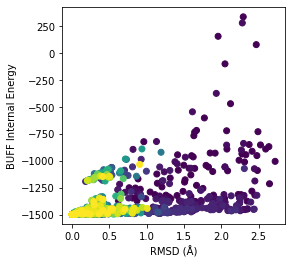

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_CC-Tri_up_down_up-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std   	min     	max    
0  	100  	-1232.78	204.04	-1473.46	-443.97
1  	100  	-1340.08	93.0545	-1473.46	-987.337
2  	100  	-1388.12	63.7494	-1473.46	-1020.49
3  	100  	-1418.37	38.1018	-1477.05	-1340.8 
4  	100  	-1436.89	31.801 	-1484.79	-1359.14
5  	100  	-1449.71	23.6934	-1488   	-1368.57
6  	100  	-1458.31	19.4102	-1488   	-1370.88
7  	100  	-1466.13	11.1501	-1488   	-1433.56
8  	100  	-1472.01	9.92522	-1489.58	-1447.4 
9  	100  	-1477.33	8.03047	-1491.5 	-1454.39
10 	100  	-1482   	5.63502	-1492.97	-1465.04
11 	100  	-1483.82	5.03915	-1493.38	-1472.6 
12 	100  	-1485.89	4.13159	-1493.77	-1472.97
13 	100  	-1487.42	3.57602	-1494.13	-1476.7 
14 	100  	-1488.8 	2.93506	-1494.13	-1480.38
15 	100  	-1489.49	2.62578	-1494.13	-1480.38
16 	100  	-1490.45	2.21765	-1494.75	-1483.61
17 	100  	-1491.16	1.96107	-1494.75	-1484.61
18 	100  	-1492.07	1.55016	-1494.75	-1487.56
19 	100  	-1492.51	1.33456	-1494.75	-1489.14
20 	100  	-1492.77	1.21655	-1494.96	-1489.53
21 	100  	-149

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1496.5660867557992

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

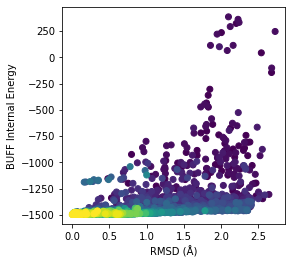

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_CC-Tri_up_down_up-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1246.73	179.379	-1485.32	-839.118
1  	85   	-1335.7 	155.753	-1485.56	-823.193
2  	58   	-1378.77	77.7712	-1479.09	-1037.97
3  	77   	-1288.99	174.863	-1479.78	-834.416
4  	82   	-1350.56	119.963	-1474.95	-886.86 
5  	81   	-1352.31	113.2  	-1477.78	-1029.25
6  	58   	-1304.05	146.725	-1482.78	-862.4  
7  	91   	-1253.3 	161.783	-1483.99	-792.272
8  	90   	-1301.53	181.91 	-1474.42	-742.606
9  	71   	-1324.62	174.558	-1473.44	-355.189
10 	71   	-1359.49	70.3609	-1475.73	-1018.12
11 	64   	-1317.26	132.447	-1480.7 	-861.978
12 	78   	-1272.62	187.179	-1483.18	-798.604
13 	78   	-1348.57	136.25 	-1481.39	-884.204
14 	70   	-1348.01	115.176	-1463.32	-744.506
15 	72   	-1310.34	108.203	-1439.3 	-875.989
16 	79   	-1330.32	138.381	-1481.02	-857.17 
17 	80   	-1328.75	106.991	-1476.32	-986.455
18 	69   	-1341.03	140.172	-1491.05	-799.029
19 	75   	-1366.74	97.2659	-1474.86	-848.314
20 	62   	-1329.6 	99.1049	-1482.87	-1008.8 
21 	85   	

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1491.0538490548984

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

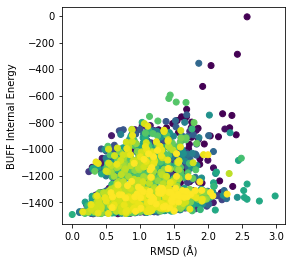

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_CC-Tri_up_down_up-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1096.06	167.241	-1432.48	-461.003
1  	100  	-1183.05	206.747	-1476.92	-188.279
2  	100  	-1232.58	279.32 	-1466.07	697.97  
3  	100  	-1375.98	91.0465	-1480.5 	-980.361
4  	100  	-1447.79	24.7601	-1484.72	-1351.34
5  	100  	-1454.75	36.3062	-1493.44	-1159.64
6  	100  	-1464.69	37.8958	-1493.33	-1159.97
7  	100  	-1474.56	44.09  	-1493.94	-1158.3 
8  	100  	-1487.79	5.57609	-1494.22	-1457.48
9  	100  	-1486.64	8.65979	-1494.41	-1448.16
10 	100  	-1488.19	8.81905	-1494.37	-1439.56
11 	100  	-1491.4 	4.30033	-1494.95	-1470.08
12 	100  	-1490.54	4.6866 	-1494.71	-1478.03
13 	100  	-1493.31	1.83876	-1495.04	-1483.45
14 	100  	-1491.33	4.93801	-1494.95	-1475.56
15 	100  	-1493.49	2.37812	-1494.94	-1483.62
16 	100  	-1492.21	4.56905	-1495.17	-1476.86
17 	100  	-1493.85	2.18509	-1496.53	-1484.07
18 	100  	-1494.07	1.66125	-1495.44	-1484.66
19 	100  	-1494.47	0.862553	-1495.87	-1489.6 
20 	100  	-1494.37	1.2055  	-1496.54	-1487.32
21 	100 

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1496.6954816728392

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

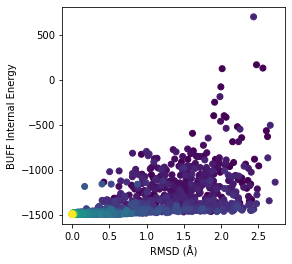

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_CC-Tri_up_down_up-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)